<a href="https://colab.research.google.com/github/autumnyyqd/hello-world/blob/master/modified_izhikevich_RS_final_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project description:**

This project added the effect of the Ultrasonic-magnetic and mechanoelectrial based on paper:

Zhang, S., Cui, K., Zhang, X., Shi, X., Ge, M., Zhao, M., Xu, G., & Yan, W. (2018). Effect of Transcranial Ultrasonic-Magnetic Stimulation on Two Types of Neural Firing Behaviors in Modified Izhikevich Model. IEEE Transactions on Magnetics, 54(3), 1–4. https://doi.org/10.1109/TMAG.2017.2773086

The paper adds an additional part to the original Izhikevich model:

\begin{align} C_{m} \frac {dv}{dt}=&0.04v^{2}+5v+140-u+I \\ \frac {du}{dt}=&a(bv-u) \\ C_{m}=&C_{m0} +C_{\textrm {Amp}} \sin (2\pi ft). \end{align}

What I did in the following code is:

1.  Add the function:

\begin{align} C_{m}=&C_{m0} +C_{\textrm {Amp}} \sin (2\pi ft). \end{align}

2. Add parameters in this additional function, same as the value described in the paper

3. Used parameters a,b,c,d, same as the values described in the paper.

4.  model the results using three different input currents, as described in the paper.

** I modeled the regular spiking mode, but I didn't model the fast spiking mode which was also included in the model.

## Result

The modeling result shows that with the higher current density, the firing rate increases, the interspike interval decrease.

In [3]:
# Modified Izhikevich Model Simulation with TUMS Effects (RS only)

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Time settings
dt = 0.02  # time step (ms) CHANGE MADE: changed dt from 0.1 to 0.02
t_max = 200  # total time (ms)
time = np.arange(0, t_max, dt)

In [5]:
# Ultrasonic–magnetic and mechanoelectrical parameters
f = 0.69e6  # ultrasound frequency in Hz
Cm0 = 1.0  # baseline membrane capacitance (uF/cm^2)
CAmp = 0.8  # amplitude of capacitance oscillation due to mechanoelectrical effect

In [6]:
# Current values to test
I_values = [17, 27, 37]  # current step amplitude (μA/cm²)


# RS Neuron parameters
neuron_params = {"a": 0.02, "b": 0.2, "c": -65, "d": 6}

V_rest = -65

def izhikevich_model(I_input, include_mechanoelectrical, time, neuron_params, Cm0, CAmp, f, dt, V_rest):
    """
    Define the evolution of state variables v and u, according to the differential equations of the model.
    """

    a, b, c, d = neuron_params["a"], neuron_params["b"], neuron_params["c"], neuron_params["d"]

    # Maximal spike value
    max_value = 30

    # Setting potential (mV)
    V = np.zeros(len(time))
    V[0] = V_rest

    # Set recovery variable
    u = np.zeros(len(time))
    u[0] = -15

    # CHANGE: create constant input current, make sure the index of I can be used in the later function.
    I_current = np.full(len(time), I_input)

    for t_step in range(1, len(time)):
        if V[t_step-1] < max_value:
            # The NEW FUNCTION ADDED TO IZHIKEVICH MODEL: CHANGE: reorganized the if and else,
            if include_mechanoelectrical:
                Cm = Cm0 + CAmp * np.sin(2 * np.pi * f * time[t_step] / 1e3)
            else:
                Cm = Cm0

            # Membrane potential evolution
            dV = ((0.04 * V[t_step-1] + 5) * V[t_step-1] + 140 - u[t_step-1] + I_current[t_step-1]) / Cm
            V[t_step] = V[t_step-1] + dV * dt

            # Recovery variable evolution
            du = a * (b * V[t_step-1] - u[t_step-1])
            u[t_step] = u[t_step-1] + dt * du

        else:
            # Peak reached
            V[t_step-1] = max_value
            # Reset membrane potential
            V[t_step] = c
            # Reset recovery variable
            u[t_step] = u[t_step-1] + d

    return time, V

In [7]:
#CHANGE: added code to show the difference of sike rate under different parameters.

#Count of Spikes
def count_spikes(V, threshold=0):  #assume Vm over 0 count as a spike
    """Count the number of spikes (upward crossings of threshold)"""
    spikes = 0
    for i in range(1, len(V)):
        if V[i-1] < threshold and V[i] >= threshold:
            spikes += 1
    return spikes

#The Firing rate in Hz
def calculate_firing_rate(V, time, threshold=0):
    """Calculate firing rate in Hz"""
    spike_count = count_spikes(V, threshold)
    duration_s = (time[-1] - time[0]) / 1000  # convert ms to s
    return spike_count / duration_s

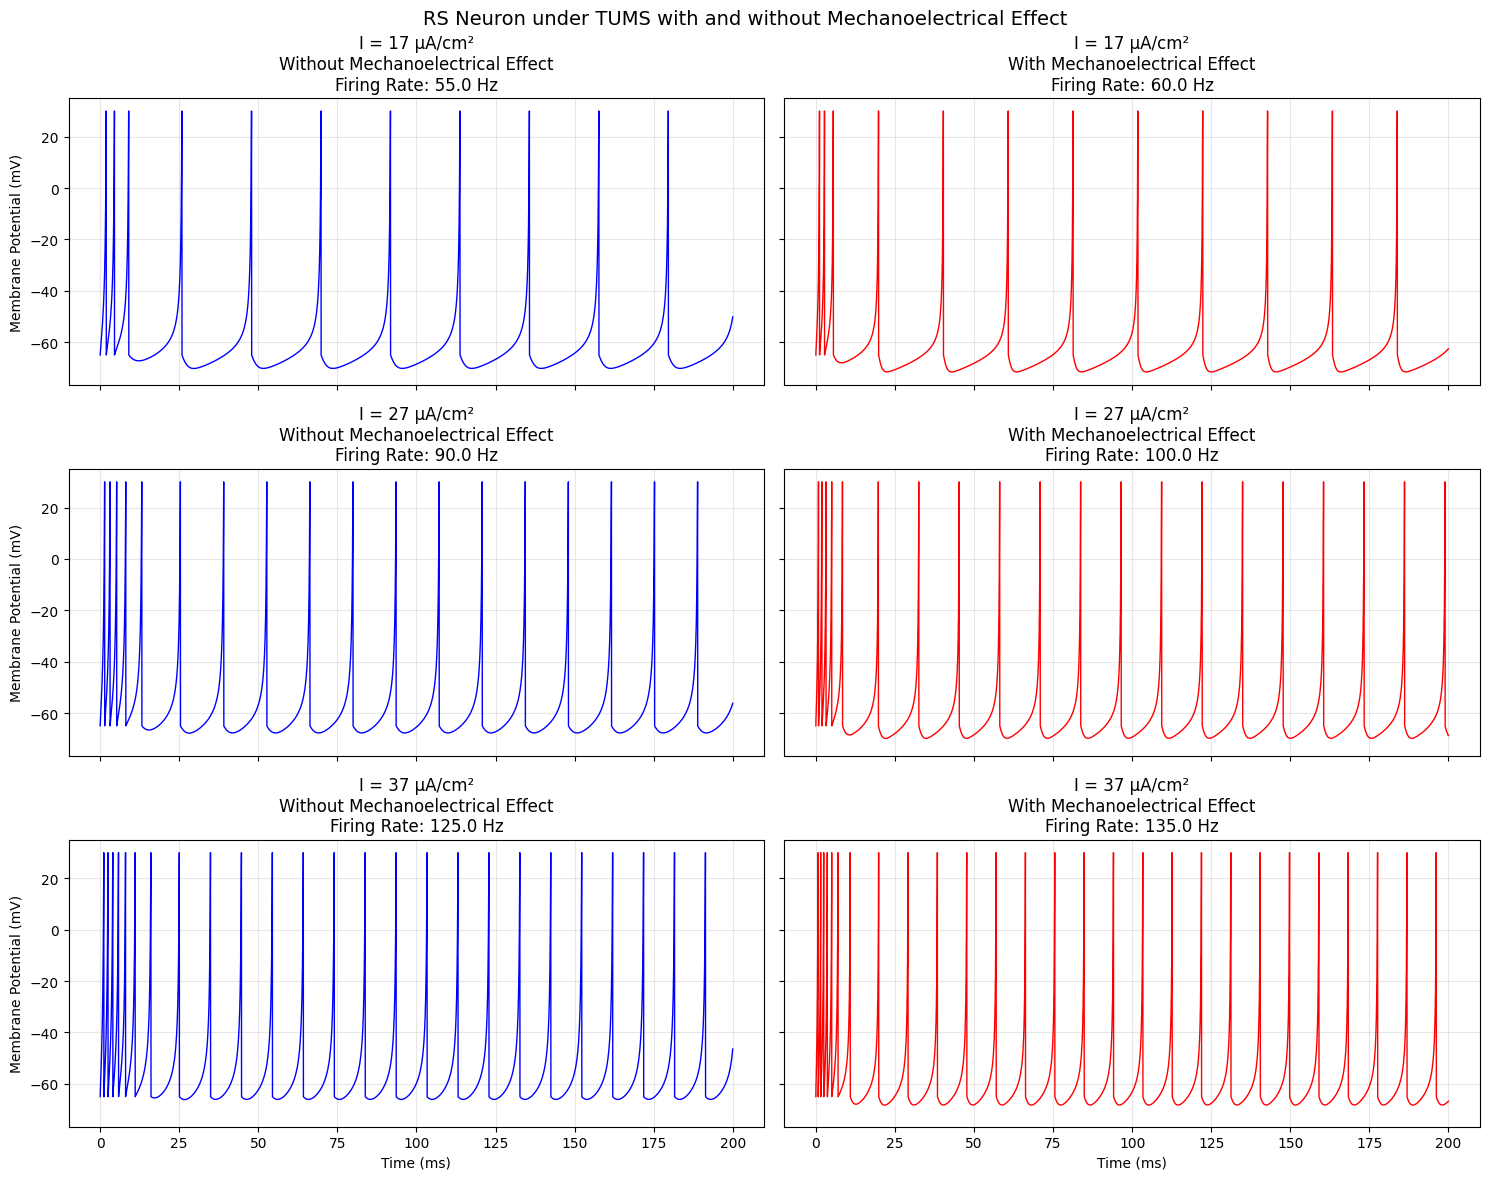

In [10]:
# Plotting results
fig, axs = plt.subplots(len(I_values), 2, figsize=(15, 12), sharex=True, sharey=True)

if len(I_values) == 1:
    axs = np.array([axs])

for idx, I_input in enumerate(I_values):
    # Fixed function calls - all arguments are now positional
    time1, V1 = izhikevich_model(I_input, False, time, neuron_params, Cm0, CAmp, f, dt, V_rest)
    time2, V2 = izhikevich_model(I_input, True, time, neuron_params, Cm0, CAmp, f, dt, V_rest)

    # Calculate firing rates for display in titles
    fr1 = calculate_firing_rate(V1, time1)
    fr2 = calculate_firing_rate(V2, time2)

    # Plot results
    axs[idx, 0].plot(time1, V1, color='blue', linewidth=1)
    axs[idx, 0].set_title(f"I = {I_input} μA/cm²\nWithout Mechanoelectrical Effect\nFiring Rate: {fr1:.1f} Hz")
    axs[idx, 0].grid(True, alpha=0.3)

    axs[idx, 1].plot(time2, V2, color='red', linewidth=1)
    axs[idx, 1].set_title(f"I = {I_input} μA/cm²\nWith Mechanoelectrical Effect\nFiring Rate: {fr2:.1f} Hz")
    axs[idx, 1].grid(True, alpha=0.3)

# Set labels
for ax in axs[-1, :]:
    ax.set_xlabel("Time (ms)")
for ax in axs[:, 0]:
    ax.set_ylabel("Membrane Potential (mV)")

fig.suptitle("RS Neuron under TUMS with and without Mechanoelectrical Effect", fontsize=14)
plt.tight_layout()
plt.show()